# Прогнозирование оттока клиентов оператора связи

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL) или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime

import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split 
from sklearn.feature_selection import SequentialFeatureSelector 
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

# Загрузка

In [ ]:
try:
    contract_df = pd.read_csv('/datasets/final_provider/contract.csv')
    internet_df = pd.read_csv('/datasets/final_provider/internet.csv')
    phone_df = pd.read_csv('/datasets/final_provider/phone.csv')
    personal_df = pd.read_csv('/datasets/final_provider/personal.csv')
except:
    contract_df = pd.read_csv('contract.csv')
    internet_df = pd.read_csv('internet.csv')
    phone_df = pd.read_csv('phone.csv')
    personal_df = pd.read_csv('personal.csv')

# Предобработка

## Contract

In [ ]:
# выведем на экран первые пять строк
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Первичные наблюдения:

* названия колонок написаны не в змеином формате
* даты отражают год и месяц
* далее - три категориальных признака
* два признака численных

In [ ]:
# приведём названия колонок к змеиному формату
contract_df.columns = (['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'])

In [ ]:
# посмотрим есть ли пропуски и какие типы данных в колонках
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


пропусков нет

данные в следующих колонках нуждаются в смене формата:

* BeginDate - на datetime
* EndDate - на datetime
* PaperlessBilling - на boolean или integer (0 или 1)
* TotalCharges - на float64

### customer_id

In [ ]:
# проверим уникальны ли уникальные идентификаторы

contract_df[contract_df['customer_id'].duplicated() == True]['customer_id'].count()

0

### begin_date

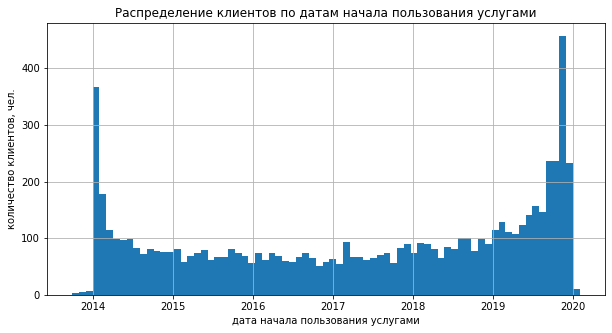

In [ ]:
# поменяем формат данных столбца begin_date и выведем гистограмму по нему

plt.figure(figsize=(10,5))
contract_df['begin_date'] = pd.to_datetime(contract_df['begin_date'])
contract_df['begin_date'].hist(bins = 75);
plt.title('Распределение клиентов по датам начала пользования услугами')
plt.xlabel('дата начала пользования услугами')
plt.ylabel('количество клиентов, чел.');

Данные охватывают период с конца 2013 г по начало 2020 г. Распределение имеет две вершины - в начале 2014 и в конце 2020 года. В конце 2013 года и начале 2020 данные, скорее всего, не полные, поскольку скачки на границе 2013/2014 и 2019/2020 слишком резкие и неправдоподобные. Следует избавиться от этих данных как недостоверных

In [ ]:
contract_df = contract_df.query('begin_date >= 2014 and begin_date <= 2020')

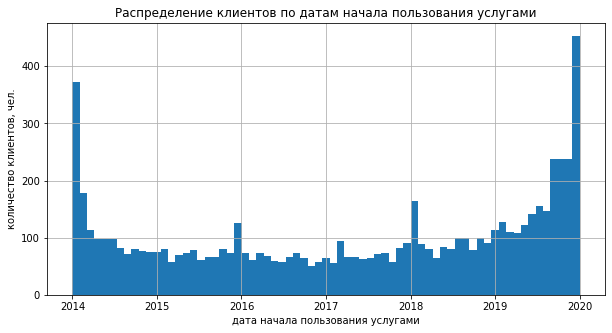

In [ ]:
# оценим результат без проблемных данных

plt.figure(figsize=(10,5))
contract_df['begin_date'].hist(bins = 69);
plt.title('Распределение клиентов по датам начала пользования услугами')
plt.xlabel('дата начала пользования услугами')
plt.ylabel('количество клиентов, чел.');

дата актуальности данных, в таком случае, должна быть смещена на 2020-01-01

### end_date

In [ ]:
# количество категорий в колонке end_date

contract_df['end_date'].value_counts()

No                     5163
2019-11-01 00:00:00     484
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     451
Name: end_date, dtype: int64

довольно странно видеть всего четыре месяца когда около 2000 клиентов прекратили пользоваться услугами. Скорее всего таких месяцев было больше, следует узнать полноту предоставленных данных

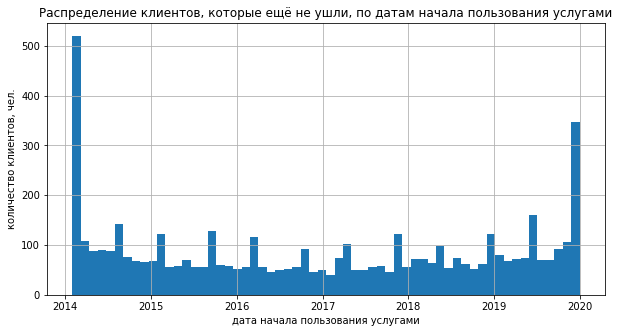

In [ ]:
# рассмотрим распределение по тем клиентам, что ещё не ушли

plt.figure(figsize=(10,5)) 
contract_df[contract_df['end_date'] == 'No']['begin_date'].hist(bins = 60);
plt.title('Распределение клиентов, которые ещё не ушли, по датам начала пользования услугами')
plt.xlabel('дата начала пользования услугами')
plt.ylabel('количество клиентов, чел.');

### создание новых признаков

In [ ]:
# функция, создающая бинарный признак ухода клиента (целевая метрика)

def lost_fill(row):
  if row['end_date'] == 'No':
    row['lost'] = 0
  else:
    row['lost'] = 1
  return row 

In [ ]:
# применение функции к датафрейму

contract_df = contract_df.apply(lost_fill, axis = 1)

In [ ]:
# функция, заполняющая значения 'No' датой актуальности данных

def end_date_fill(row):
  if row['end_date'] == 'No':
    row['end_date'] = '2020-01-01 00:00:00'
  return row 

In [ ]:
# применение функции к датафрейму

contract_df = contract_df.apply(end_date_fill, axis = 1)

In [ ]:
# проверим результат
contract_df['end_date'].value_counts()

2020-01-01 00:00:00    5623
2019-11-01 00:00:00     484
2019-12-01 00:00:00     466
2019-10-01 00:00:00     451
Name: end_date, dtype: int64

In [ ]:
# теперь можно сменить формат данных с датами

contract_df['end_date'] = pd.to_datetime(contract_df['end_date'])

In [ ]:
# создадим новую колонку, отражающую длительность пользования клиентом услугами

contract_df['duration'] = contract_df['end_date'] - contract_df['begin_date']

In [ ]:
# посмотрим на результат

contract_df['duration'].sort_values()

0         0 days
3810      0 days
556       0 days
3802      0 days
1774      0 days
          ...   
1902   2160 days
6579   2160 days
3890   2191 days
3111   2191 days
6424   2191 days
Name: duration, Length: 7024, dtype: timedelta64[ns]

In [ ]:
# количество клиентов, ушедших в день регистрации 

contract_df.query('duration == "0 days" and lost == 1')['duration'].count()

0

In [ ]:
# перевод длительности пользования услугами в формат целых чисел

contract_df['duration'] = (contract_df["duration"] / np.timedelta64(1, 'D')).astype(int)

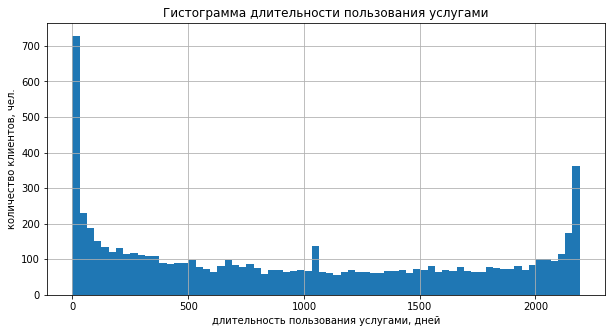

In [ ]:
# визуализация нового признака

plt.figure(figsize=(10,5)) 
contract_df['duration'].hist(bins = 70)
plt.title('Гистограмма длительности пользования услугами')
plt.xlabel('длительность пользования услугами, дней')
plt.ylabel('количество клиентов, чел.');

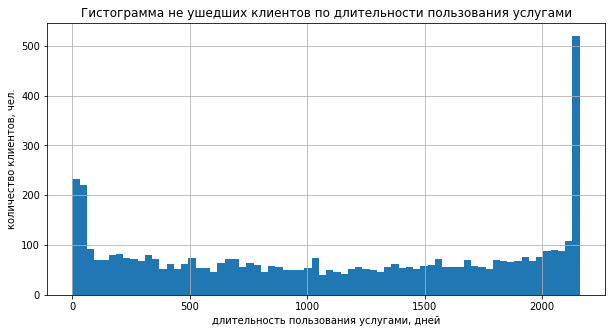

In [ ]:
# гистограмма не ушедших клиентов по длительности пользования услугами 

plt.figure(figsize=(10,5))
contract_df[contract_df['lost'] == 0]['duration'].hist(bins = 70);
plt.title('Гистограмма не ушедших клиентов по длительности пользования услугами')
plt.xlabel('длительность пользования услугами, дней')
plt.ylabel('количество клиентов, чел.');

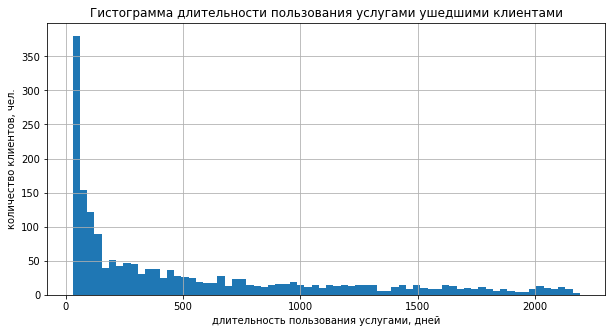

In [ ]:
# гистограмма длительности пользования услугами ушедшими клиентами

plt.figure(figsize=(10,5))
contract_df[contract_df['lost'] == 1]['duration'].hist(bins = 70);
plt.title('Гистограмма длительности пользования услугами ушедшими клиентами')
plt.xlabel('длительность пользования услугами, дней')
plt.ylabel('количество клиентов, чел.');

In [ ]:
contract_df[contract_df['lost'] == 1]['duration'].describe()

count    1861.000000
mean      540.401397
std       586.108554
min        30.000000
25%        61.000000
50%       303.000000
75%       883.000000
max      2191.000000
Name: duration, dtype: float64

In [ ]:
contract_df[contract_df['lost'] == 1]['duration'].mode()

0    31
dtype: int64

Вывод: чаще всего клиенты уходят в течение месяца после регистрации

### type

In [ ]:
contract_df['type'].value_counts()

Month-to-month    3875
Two year          1678
One year          1471
Name: type, dtype: int64

Больше всего клиентов пользуются тарифом "Month-to-month"

### paperless_billing

In [ ]:
contract_df['paperless_billing'].value_counts()

Yes    4162
No     2862
Name: paperless_billing, dtype: int64

Большинство клиентов предпочитают получать счёт электронным способом, но и тех, кто получает счёт на бумаге всё ещё много

### payment_method

In [ ]:
contract_df['payment_method'].value_counts()

Electronic check             2364
Mailed check                 1604
Bank transfer (automatic)    1538
Credit card (automatic)      1518
Name: payment_method, dtype: int64

Большинство клиентов оплачивают услуги электронным чеком

### monthly_charges

In [ ]:
# рассмотрим данные по месячной оплате
contract_df['monthly_charges'].describe()

count    7024.000000
mean       64.757510
std        30.074239
min        18.250000
25%        35.537500
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

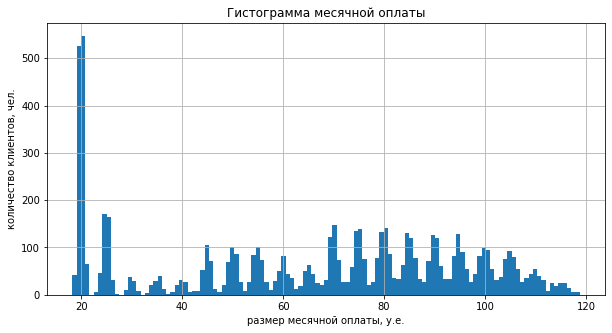

In [ ]:
# рассмотрим их на гистограмме

plt.figure(figsize=(10,5))
contract_df['monthly_charges'].hist(bins = 119);
plt.title('Гистограмма месячной оплаты')
plt.xlabel('размер месячной оплаты, у.е.')
plt.ylabel('количество клиентов, чел.');

кратность тарифной сетки близка к 5

наиболее частый тариф 20, далее - 25 и 70, примерно такие же по популярности 75, 80, 85, 90 и 95. Реже всего встречаются 115, 30, 35 и 40

### total_charges

In [ ]:
contract_df['total_charges'].describe()

count     7024
unique    6522
top       20.2
freq        11
Name: total_charges, dtype: object

In [ ]:
# проверим наличие нечисловых значений в колонке total_charges

contract_df['total_charges'].value_counts()

20.2       11
19.75       9
19.9        8
20.05       8
19.65       8
           ..
130.15      1
3211.9      1
7843.55     1
2196.3      1
6844.5      1
Name: total_charges, Length: 6522, dtype: int64

In [ ]:
# сменим тип данных колонки total_charges

contract_df['total_charges'] = contract_df['total_charges'].astype('float64')

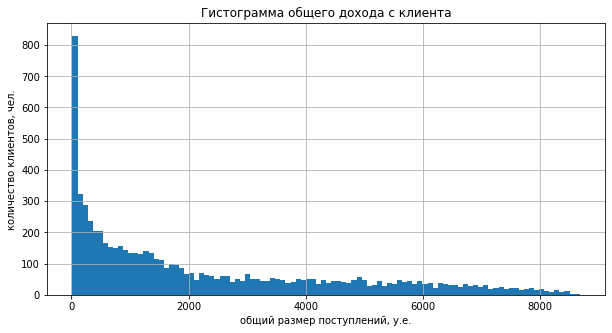

In [ ]:
plt.figure(figsize=(10,5))
contract_df['total_charges'].hist(bins=100)
plt.title('Гистограмма общего дохода с клиента')
plt.xlabel('общий размер поступлений, у.е.')
plt.ylabel('количество клиентов, чел.');

### создание новых признаков

Как известно, телекоммуникационные компании нещадно обманывают клиентов. По личному опыту это является одной из причин ухода к другому оператору. Содадим признак, отвечающий за взимание больше положенной платы с клиента

In [ ]:
# proxi для total_charges - сколько клиент должен заплатить компании исходя из стоимости услуг за месяц

contract_df['total_charges_proxi'] = contract_df['monthly_charges'] * contract_df['duration'] / 30

# следует отметить, что формула простая и имеет погрешность, связанную с различным количеством дней
# в разных месяцах. При необходимости её можно усложнить или написать функцию

In [ ]:
# посмотрим на результат

contract_df['total_charges_proxi'].describe()

count    7024.000000
mean     2265.668777
std      2269.153159
min         0.000000
25%       374.967500
50%      1385.090833
75%      3776.777500
max      8550.000000
Name: total_charges_proxi, dtype: float64

нулевые значения соответствуют клиентам, которые пробыли с компанией 0 дней 

In [ ]:
contract_df['total_charges'].describe()

count    7024.000000
mean     2277.770736
std      2261.815009
min        18.800000
25%       400.900000
50%      1395.525000
75%      3778.362500
max      8672.450000
Name: total_charges, dtype: float64

In [ ]:
# создадим новый признак, отвечающий за отклонение общей взимаемой с клиента суммы от той,
# что компания должна взимать исходя из заявленной месячной суммы
# отклонение в меньшую сумму отвечает за скидку, в большую - за грабёж

contract_df['over_charges'] = contract_df['total_charges'] - contract_df['total_charges_proxi']

In [ ]:
# посмотрим сколько компания награбила

contract_df['over_charges'].sum()

85004.1633333333

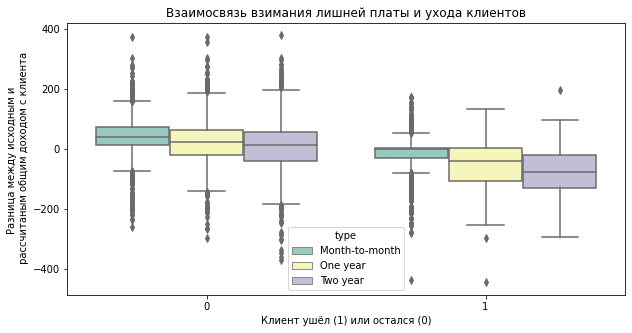

In [ ]:
# проанализируем взаимосвязь взимания лишней платы и ухода клиентов

plt.figure(figsize=(10,5))
ax = sns.boxplot(x="lost", y="over_charges", hue = 'type',
                 data=contract_df, palette="Set3");

plt.title('Взаимосвязь взимания лишней платы и ухода клиентов')
plt.xlabel('Клиент ушёл (1) или остался (0)')
plt.ylabel('Разница между исходным и \n рассчитаным общим доходом с клиента');

Как видно на графике лояльных клиентов обирают, а тех, что ушли, видимо, старались оставить, предлагая скидки (чтобы обирать потом)

Причём, больше всего обирают тех, кто пользуется тарифом "month-to-month", а больше всего выигрывают клиенты на тарифе "two years"

In [ ]:
# добавим категориальный признак наличия скидки для клиента

def discount(row):
  if row['over_charges'] < 0:
    row['discount'] = 'Yes'
  else:
    row['discount'] = 'No'
  return row

contract_df = contract_df.apply(discount, axis = 1)

### результат предобработки данных

In [ ]:
# проверим результат предобработки данных

contract_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7024 entries, 0 to 7042
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_id          7024 non-null   object        
 1   begin_date           7024 non-null   datetime64[ns]
 2   end_date             7024 non-null   datetime64[ns]
 3   type                 7024 non-null   object        
 4   paperless_billing    7024 non-null   object        
 5   payment_method       7024 non-null   object        
 6   monthly_charges      7024 non-null   float64       
 7   total_charges        7024 non-null   float64       
 8   lost                 7024 non-null   int64         
 9   duration             7024 non-null   int64         
 10  total_charges_proxi  7024 non-null   float64       
 11  over_charges         7024 non-null   float64       
 12  discount             7024 non-null   object        
dtypes: datetime64[ns](2), float64(4),

Вывод:
* в уникальных идентификаторов нет повторов
* данные охватывают период с 2014 по конец 2019 гг., неправдоподобно малочисленные данные по концу 2013 и началу 2020 гг. были отсечены
* окончание пользования услугами предоставлено, скорее всего, не в полной мере, следует запросить остальные данные
* категориальные признаки тип тарифа, электронный счёт и способ оплаты не имеют явной необходимости в предобработке
* месячная оплата и общие поступления также не имеют явной необходимости в предобработке


Были созданы новые признаки:
* lost - бинарный признак оттока клиентов, будет являться целевым в моделях
* over_charge - денежная разница, отвечающая за скидку или грабёж клиента; по всей видимости, один из важных признаков
* duration - длительность пользования услугами клиентом в днях

## Internet

In [ ]:
# выведем на экран первые пять строк

internet_df.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Первичные наблюдения:

* названия колонок написаны не в змеином формате
* признаки категориальные

In [ ]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [ ]:
internet_df.columns = (['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies'])

In [ ]:
internet_df[internet_df['customer_id'].duplicated() == True]['customer_id'].count()

0

In [ ]:
internet_df['internet_service'].value_counts()

Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64

In [ ]:
internet_df['online_security'].value_counts()

No     3498
Yes    2019
Name: online_security, dtype: int64

In [ ]:
internet_df['online_backup'].value_counts()

No     3088
Yes    2429
Name: online_backup, dtype: int64

In [ ]:
internet_df['device_protection'].value_counts()

No     3095
Yes    2422
Name: device_protection, dtype: int64

In [ ]:
internet_df['tech_support'].value_counts()

No     3473
Yes    2044
Name: tech_support, dtype: int64

In [ ]:
internet_df['streaming_tv'].value_counts()

No     2810
Yes    2707
Name: streaming_tv, dtype: int64

In [ ]:
internet_df['streaming_movies'].value_counts()

No     2785
Yes    2732
Name: streaming_movies, dtype: int64

Вывод: данные в предобработке не нуждаются

### Создание нового признака

In [ ]:
internet_df['internet_user'] = 'Yes'

## Phone

In [ ]:
phone_df.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [ ]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [ ]:
phone_df.columns = (['customer_id', 'multiple_lines'])

In [ ]:
phone_df[phone_df['customer_id'].duplicated() == True]['customer_id'].count()

0

In [ ]:
phone_df['multiple_lines'].value_counts()

No     3390
Yes    2971
Name: multiple_lines, dtype: int64

Вывод: данные в предобработке не нуждаются

## Personal

In [ ]:
personal_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
personal_df.columns = (['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'])

In [ ]:
personal_df[personal_df['customer_id'].duplicated() == True]['customer_id'].count()

0

In [ ]:
personal_df['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [ ]:
personal_df['senior_citizen'].value_counts()

0    5901
1    1142
Name: senior_citizen, dtype: int64

In [ ]:
personal_df['partner'].value_counts()

No     3641
Yes    3402
Name: partner, dtype: int64

In [ ]:
personal_df['dependents'].value_counts()

No     4933
Yes    2110
Name: dependents, dtype: int64

Вывод: данные в предобработке не нуждаются

## Объединение таблиц

In [ ]:
all_data = contract_df.merge(internet_df, how='left', on = 'customer_id')

In [ ]:
all_data = all_data.merge(phone_df, how='left', on = 'customer_id')

In [ ]:
all_data = all_data.merge(personal_df, how='left', on = 'customer_id')

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7024 entries, 0 to 7023
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_id          7024 non-null   object        
 1   begin_date           7024 non-null   datetime64[ns]
 2   end_date             7024 non-null   datetime64[ns]
 3   type                 7024 non-null   object        
 4   paperless_billing    7024 non-null   object        
 5   payment_method       7024 non-null   object        
 6   monthly_charges      7024 non-null   float64       
 7   total_charges        7024 non-null   float64       
 8   lost                 7024 non-null   int64         
 9   duration             7024 non-null   int64         
 10  total_charges_proxi  7024 non-null   float64       
 11  over_charges         7024 non-null   float64       
 12  discount             7024 non-null   object        
 13  internet_service     5504 non-nul

In [ ]:
# заполнение пропусков значением No

all_data[['internet_service',
          'online_security',
          'online_backup',
          'device_protection',
          'tech_support',
          'streaming_tv',
          'streaming_movies',
          'internet_user']] = all_data[['internet_service',
          'online_security',
          'online_backup',
          'device_protection',
          'tech_support',
          'streaming_tv',
          'streaming_movies',
          'internet_user']].fillna('No')

In [ ]:
# заполнение пропусков признака multiple_lines значением no_phone

all_data['multiple_lines'] = all_data['multiple_lines'].fillna('no_phone')

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7024 entries, 0 to 7023
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_id          7024 non-null   object        
 1   begin_date           7024 non-null   datetime64[ns]
 2   end_date             7024 non-null   datetime64[ns]
 3   type                 7024 non-null   object        
 4   paperless_billing    7024 non-null   object        
 5   payment_method       7024 non-null   object        
 6   monthly_charges      7024 non-null   float64       
 7   total_charges        7024 non-null   float64       
 8   lost                 7024 non-null   int64         
 9   duration             7024 non-null   int64         
 10  total_charges_proxi  7024 non-null   float64       
 11  over_charges         7024 non-null   float64       
 12  discount             7024 non-null   object        
 13  internet_service     7024 non-nul

## Выбор признаков

In [ ]:
# признаки с датой и промежуточным результатом total_charges_proxi для расчёта over_charges
# не нужны в дальнейшем

all_data = all_data.drop(['begin_date', 'end_date', 'total_charges_proxi'], axis = 1)

In [ ]:
# порядковое кодирование признаков

encoder = OrdinalEncoder()
all_data_ord = pd.DataFrame(encoder.fit_transform(all_data),
                            columns=all_data.columns)

(23.5, -0.5)

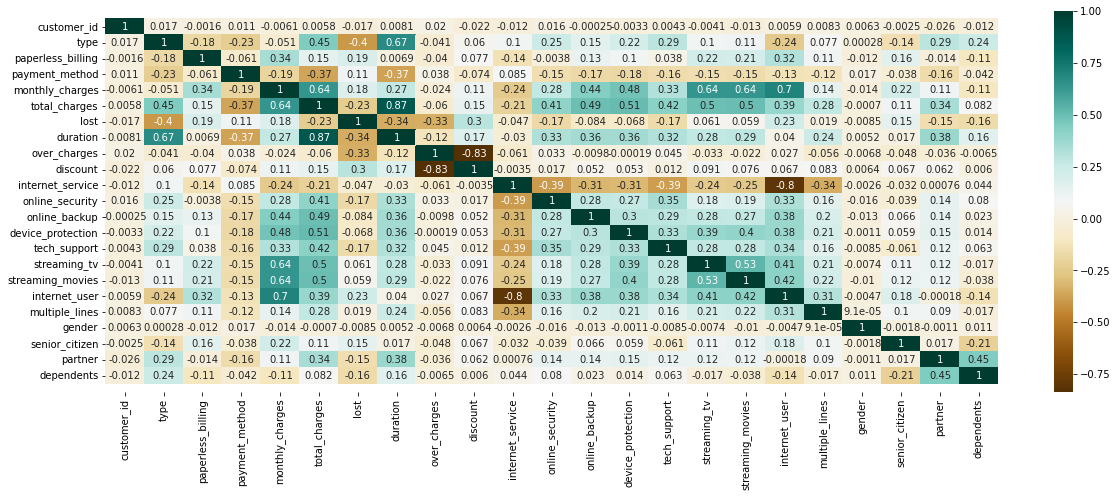

In [ ]:
# анализ взаимосвязи признаков:

plt.figure(figsize=(20, 7))

corr = all_data_ord.select_dtypes(include=[np.number]).corr()

ax = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True,
        cmap='BrBG')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

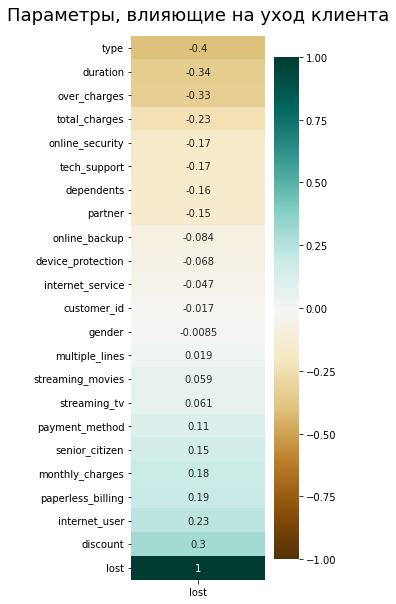

In [ ]:
plt.figure(figsize=(3, 10))
heatmap = sns.heatmap(all_data_ord.corr()[['lost']].sort_values(by='lost'), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Параметры, влияющие на уход клиента', fontdict={'fontsize':18}, pad=16);

признаки gender, customer_id, multiple_lines, streaming_movies, streaming_tv, internet_service, device_protection, online_backup  практически не влияют на целевой признак и могут быть удалены для облегчения датасета. Стоит это сделать после проведения оценки важности признаков по результатам работы первой модели

In [ ]:
!pip install phik

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

interval columns not set, guessing: ['customer_id', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges', 'lost', 'duration', 'over_charges', 'discount', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'internet_user', 'multiple_lines', 'gender', 'senior_citizen', 'partner', 'dependents']


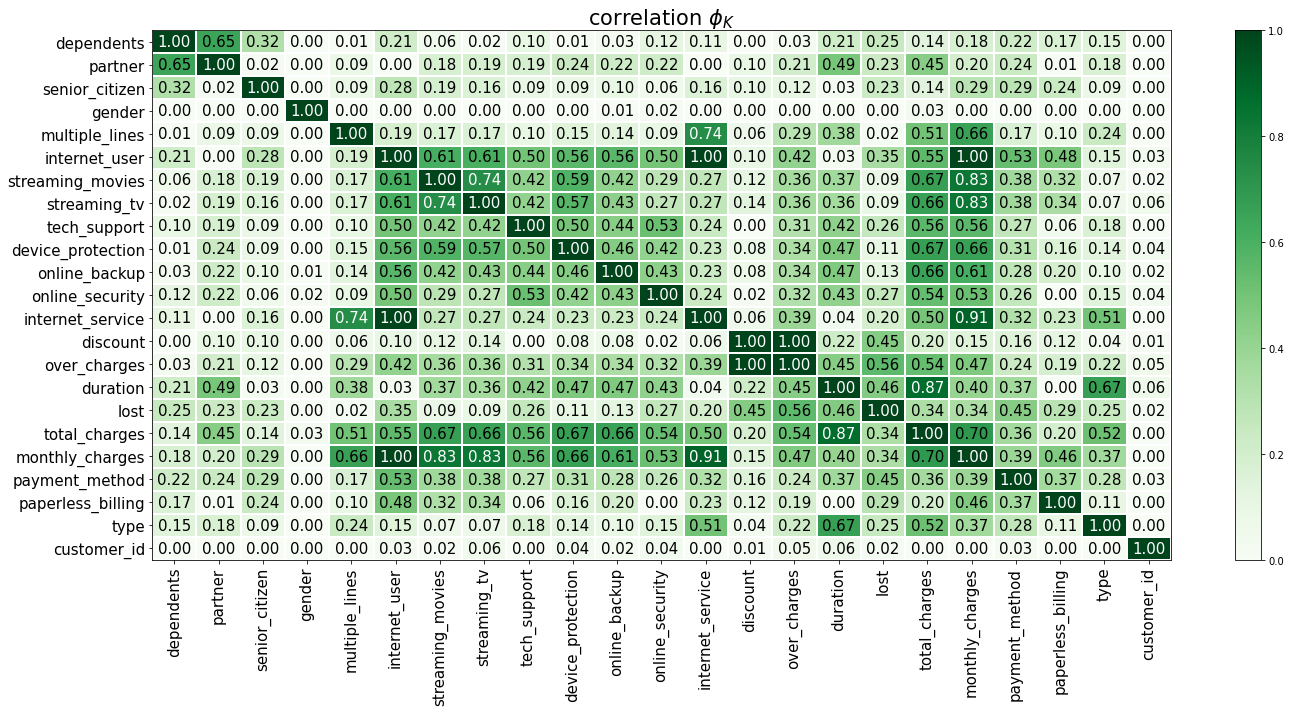

In [ ]:
phik_overview = all_data_ord.phik_matrix()

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 10))
plt.tight_layout()

Можно наблюдать корреляцию признаков:

* multiple_lines internet_service
* internet_user monthly_charges internet_service
* streaming_movies monthly_charges streming_tv
* и т.д.

Наблюдаются и слабо связанные с другими признаки:
* dependents
* partner
* senior_citizen
* gender
* customer_id

interval columns not set, guessing: ['customer_id', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges', 'lost', 'duration', 'over_charges', 'discount', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'internet_user', 'multiple_lines', 'gender', 'senior_citizen', 'partner', 'dependents']


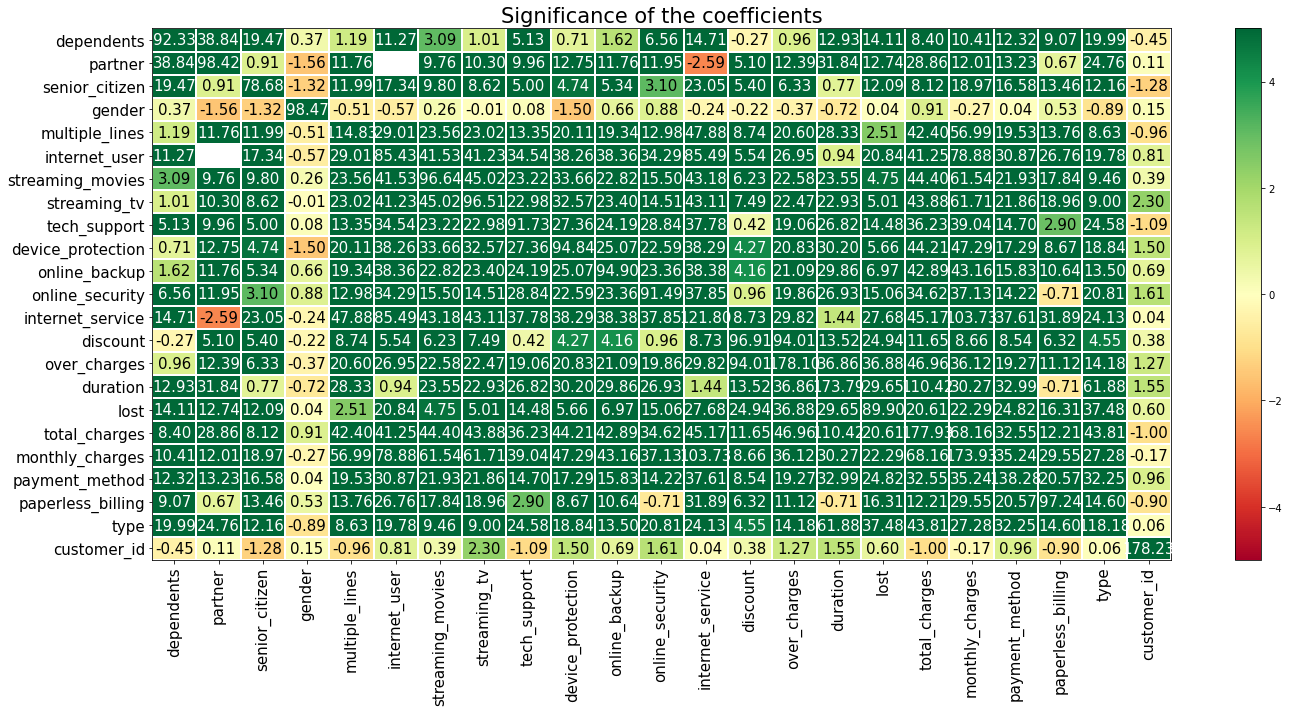

In [ ]:
significance_overview = all_data_ord.significance_matrix()
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(20, 10))
plt.tight_layout()

Статистическая значимость также важна, поскольку высокая корреляция может быть статистически незначима и наоборот

interval columns not set, guessing: ['customer_id', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges', 'lost', 'duration', 'over_charges', 'discount', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'internet_user', 'multiple_lines', 'gender', 'senior_citizen', 'partner', 'dependents']


/usr/local/lib/python3.7/dist-packages/phik/phik.py:320: RuntimeWarning: invalid value encountered in sqrt
  1 - (1 / (np.diagonal(V) * np.diagonal(Vinv)))


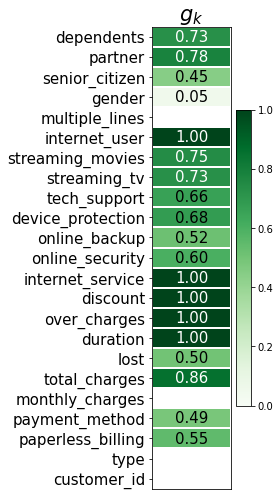

In [ ]:
global_correlation, global_labels = all_data_ord.global_phik()

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(4,7),
                        color_map="Greens", title=r"$g_k$",
                        fontsize_factor=1.5)
plt.tight_layout()

Коэфициент глобальной корреляции отражает общую корреляцию одной переменной ко всем другим переменным датасета. Это даёт представление о том, насколько хорошо одна переменная может быть смоделирована на основе других

## Исследовательский анализ

Проанализируем возможные нелинейные зависимости и связь категориальных признаков с уходом клиентов

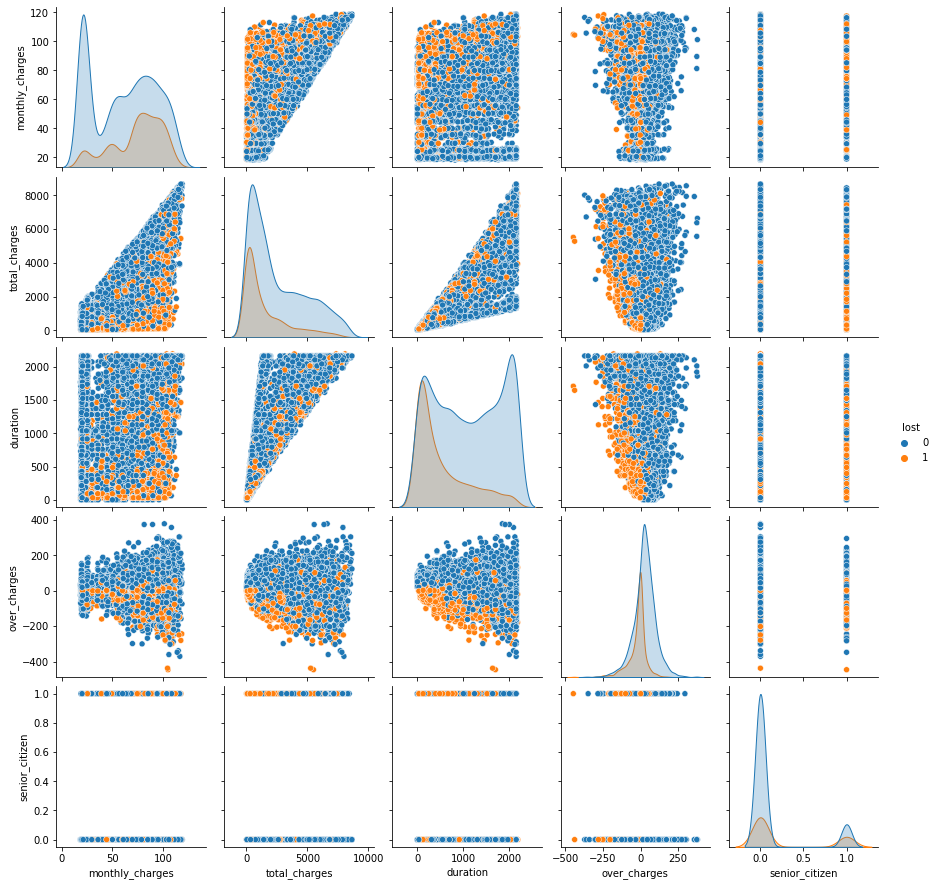

In [ ]:
sns.pairplot(all_data, hue = "lost");

Клиенты, которые ушли:
* имели большие monthly_charges, но малые total_charges и duration, что исходит из того, что клиенты уходили последние месяцы 2019 года, непосредственно перед датой актуальности данных

In [ ]:
df_pairplot = all_data.drop(['customer_id', 'monthly_charges', 'total_charges', 'duration', 'over_charges'], axis = 1)
melted = pd.melt(df_pairplot, id_vars = "lost", value_vars = ('type', 'paperless_billing', 'payment_method',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines', 'gender', 'partner', 'dependents'))

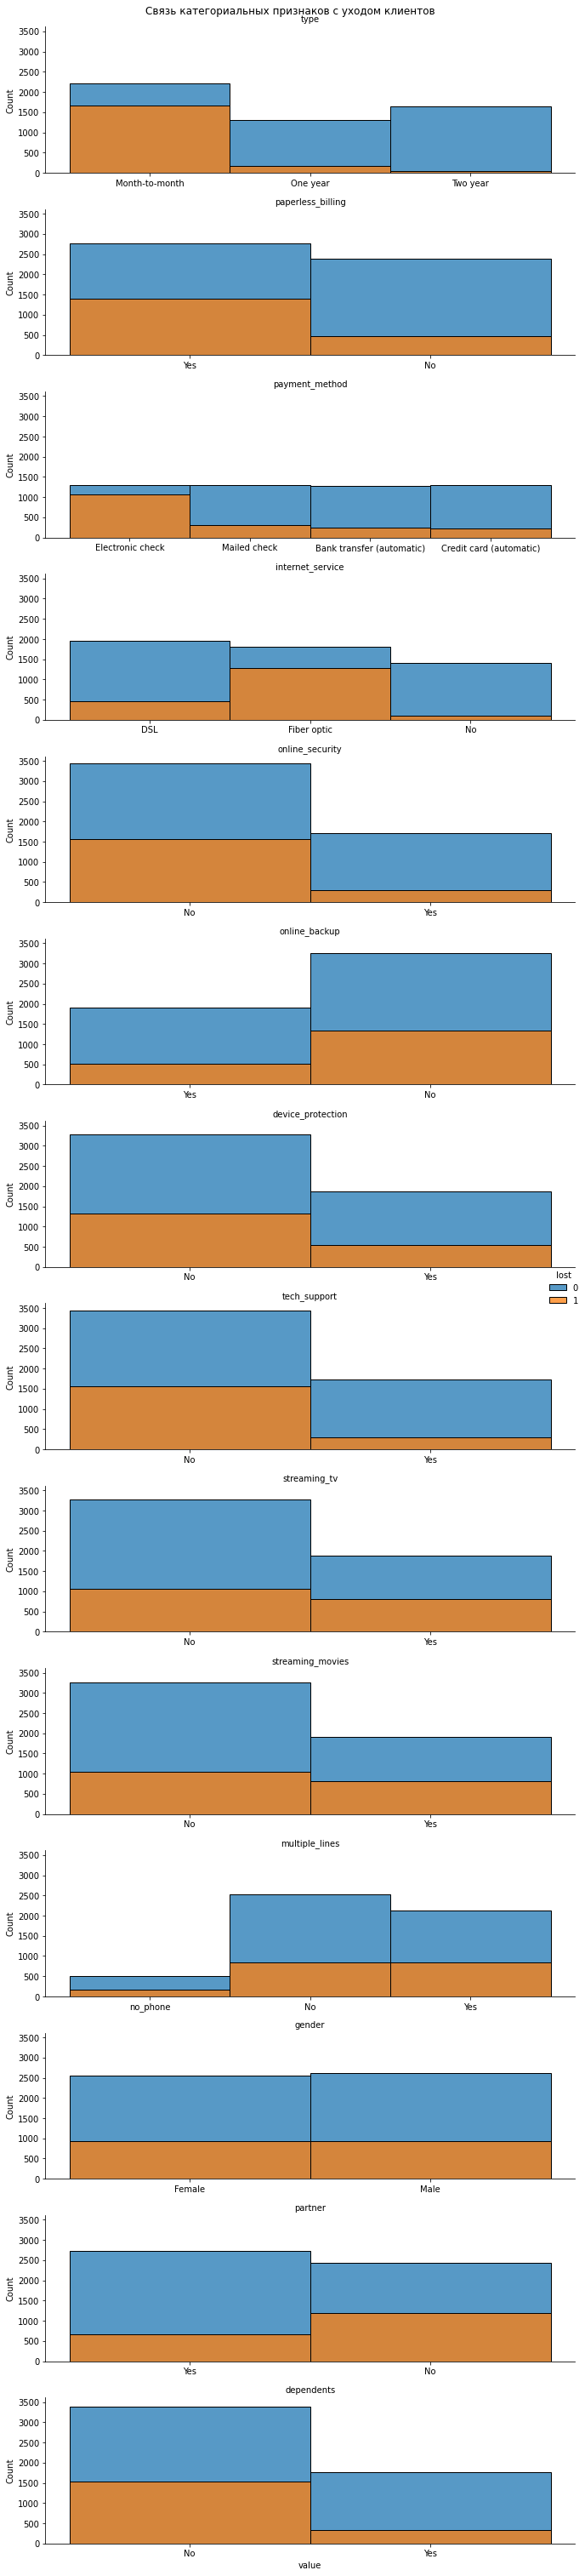

In [ ]:
g = sns.FacetGrid(melted, row = 'variable', hue = 'lost', sharex = False, aspect = 3);
g.fig.suptitle('Связь категориальных признаков с уходом клиентов', y=1)
plot = g.map(sns.histplot, 'value', common_bins=False, multiple="stack").add_legend().set_titles("{row_name}");
g.fig.tight_layout()

Клиенты уходят в основном при следующих условиях:
* type: Month-to-month,
* paperless_billing: Yes,
* payment_method: Electronic check,
* internet_service: Fiber optic,
* online_security: No,
* online_backup: No,
* device_protection: No,
* tech_support: No,
* streaming_tv: No,
* streaming_movies: No,
* miltiple_lines: no_phone,
* partner: No,
* dependents: No

От пола и количества подключённых телефонных линий зависимости нет

Вывод: клиенты, которые уходили, не подключали дополнительных услуг, но имели высокий ежемесячный платёж

# Подготовка данных

## Разделение данных на выборки

In [ ]:
features = all_data.drop('lost', axis = 1)
target = all_data['lost']

print('features shape:', features.shape)
print('target shape:',target.shape)

features shape: (7024, 22)
target shape: (7024,)


In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = 0.2, random_state = 80822, stratify = target)

print('features_train', features_train.shape)
print('features_test', features_test.shape)

print('target_train', target_train.shape)
print('target_test', target_test.shape)

features_train (5619, 22)
features_test (1405, 22)
target_train (5619,)
target_test (1405,)


In [ ]:
numeric = ['monthly_charges', 'total_charges', 'duration', 'over_charges']
categorial = ['type', 'paperless_billing', 'payment_method',
       'discount', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'internet_user', 'multiple_lines', 'gender', 'senior_citizen',
       'partner', 'dependents']

## Кодирование категориальных признаков

In [ ]:
encoder = OrdinalEncoder()

features_train_ord = pd.DataFrame(encoder.fit_transform(features_train),
                            columns=features_train.columns)

features_test_ord = pd.DataFrame(encoder.fit_transform(features_test),
                            columns=features_test.columns)

In [ ]:
one_hot = pd.get_dummies(features_train.drop(numeric, axis = 1), drop_first=True, columns = categorial)

features_train_ohe = features_train.merge(one_hot).drop(categorial, axis = 1)

one_hot = pd.get_dummies(features_test.drop(numeric, axis = 1), drop_first=True, columns = categorial)

features_test_ohe = features_test.merge(one_hot).drop(categorial, axis = 1)

## Масштабирование количественных признаков

In [ ]:
scaler = StandardScaler()

scaler.fit(features_train_ord[numeric])
features_train_ord[numeric] = scaler.transform(features_train_ord[numeric])
features_test_ord[numeric] = scaler.transform(features_test_ord[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

## Выбор значимых признаков

### На основе логистической регрессии

In [ ]:
features_train_ohe = features_train_ohe.drop('customer_id', axis = 1)
features_test_ohe = features_test_ohe.drop('customer_id', axis = 1)

#### Кодировка One Hot Encoder

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


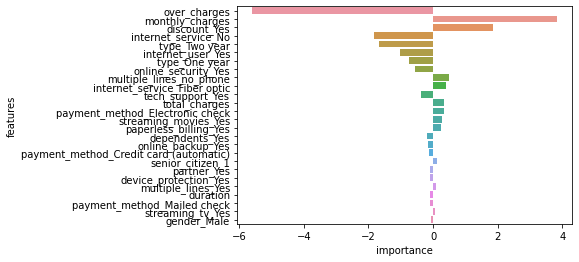

In [ ]:
lr_model = LogisticRegression(class_weight = 'balanced', random_state=80822)
lr_model.fit(features_train_ohe, target_train)
lr_importance = lr_model.coef_[0]

lr_feature_importance_df = pd.DataFrame(
    {'features': features_train_ohe.columns.tolist(),
     'importance': lr_importance.tolist()
    })

lr_feature_importance_df['abs'] = abs(lr_feature_importance_df['importance'])

sns.barplot(data = lr_feature_importance_df.sort_values(by = 'abs', ascending = False), y = 'features', x = 'importance', orient = 'h');

Наиболее важные признаки для логистической регрессии:
* over_charges
* monthly_charges
* discount
* type
* internet_service

Наименее важные признаки для логистической регрессии:

* gender
* streaming_tv
* duration
* multiple_lines
* device_protection

In [ ]:
r = permutation_importance(lr_model, features_train_ohe, target_train,
                           n_repeats=5,
                           scoring ='roc_auc',
                           random_state=80822)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{features_train_ohe.columns[i]:<8} "
              f"{r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f}")

duration 0.149  +/- 0.004
discount_Yes 0.075  +/- 0.003
internet_service_No 0.038  +/- 0.003
type_Two year 0.029  +/- 0.004
total_charges 0.014  +/- 0.001
over_charges 0.011  +/- 0.001
internet_user_Yes 0.010  +/- 0.001
type_One year 0.007  +/- 0.001
online_security_Yes 0.005  +/- 0.001
monthly_charges 0.004  +/- 0.001
internet_service_Fiber optic 0.003  +/- 0.000
tech_support_Yes 0.002  +/- 0.001
multiple_lines_no_phone 0.002  +/- 0.000
payment_method_Electronic check 0.001  +/- 0.001
streaming_movies_Yes 0.001  +/- 0.001
dependents_Yes 0.000  +/- 0.000


Наиболее важные признаки для логистической регрессии по permutation_importance:
* duration
* discount_Yes
* type_Two year
* internet_service_No
* total_charges

In [ ]:
%%time

selector = SequentialFeatureSelector(LogisticRegression(), scoring='roc_auc', 
                                     n_features_to_select=3, direction='forward', 
                                     n_jobs=-1)

selector.fit(features_train_ohe, target_train)

CPU times: user 1.69 s, sys: 122 ms, total: 1.81 s
Wall time: 7.87 s


SequentialFeatureSelector(estimator=LogisticRegression(),
                          n_features_to_select=3, n_jobs=-1, scoring='roc_auc')

In [ ]:
np.array(features_train_ohe.columns)[selector.get_support()]

array(['monthly_charges', 'duration', 'over_charges'], dtype=object)

Наиболее важные признаки для логистической регрессии по SequentialFeatureSelector:

* monthly_charges
* duration
* over_charges

Наиболее важные признаки для логистической регрессии:

количественные:
* over_charges
* monthly_charges
* duration
* total_charges

(т.е. все)

категориальные:
* discount
* type
* internet_service
* discount
* type
* internet_user
* paperless_billing
* discount
* streaming_movies

### На основе модели случайного леса

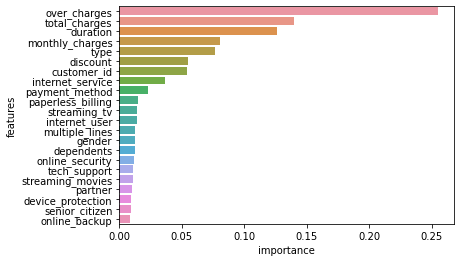

In [ ]:
rf_model = RandomForestClassifier(n_estimators = 9, random_state=80822)
rf_model.fit(features_train_ord, target_train)

rf_importance = rf_model.feature_importances_

rf_feature_importance_df = pd.DataFrame(
    {'features': features_train_ord.columns.tolist(),
     'importance': rf_importance.tolist()
    })

rf_feature_importance_df['abs'] = abs(rf_feature_importance_df['importance'])

sns.barplot(data = rf_feature_importance_df.sort_values(by = 'abs', ascending = False), y = 'features', x = 'importance', orient = 'h');

Наиболее важные признаки для модели случайного леса:

* over_charges
* total_charges
* duration
* monthly_charges
* type
* discount
* internet_service

In [ ]:
r = permutation_importance(rf_model, features_train_ord, target_train,
                           n_repeats=5,
                           scoring ='roc_auc',
                           random_state=80822)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{features_train_ord.columns[i]:<8} "
              f"{r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f}")

over_charges 0.138  +/- 0.006
duration 0.038  +/- 0.002
total_charges 0.028  +/- 0.001
monthly_charges 0.020  +/- 0.001
type     0.018  +/- 0.001
discount 0.008  +/- 0.000
internet_service 0.007  +/- 0.001
payment_method 0.004  +/- 0.000
paperless_billing 0.004  +/- 0.000
customer_id 0.004  +/- 0.000
tech_support 0.003  +/- 0.000
streaming_tv 0.002  +/- 0.000
dependents 0.002  +/- 0.000
multiple_lines 0.002  +/- 0.000
online_security 0.001  +/- 0.000
partner  0.001  +/- 0.000
streaming_movies 0.001  +/- 0.000
gender   0.001  +/- 0.000
internet_user 0.001  +/- 0.000
device_protection 0.001  +/- 0.000
online_backup 0.001  +/- 0.000
senior_citizen 0.001  +/- 0.000


Наиболее важные признаки для модели случайного леса по permutation_importance:

* over_charges
* duration
* total_charges
* monthly_charges
* type
* discount
* internet_service

In [ ]:
%%time

selector = SequentialFeatureSelector(RandomForestClassifier(), scoring='roc_auc', 
                                     n_features_to_select=3, direction='forward', 
                                     n_jobs=-1)

selector.fit(features_train_ord, target_train)

CPU times: user 1.98 s, sys: 142 ms, total: 2.12 s
Wall time: 1min 28s


SequentialFeatureSelector(estimator=RandomForestClassifier(),
                          n_features_to_select=3, n_jobs=-1, scoring='roc_auc')

In [ ]:
np.array(features_train_ord.columns)[selector.get_support()]

array(['duration', 'discount', 'internet_service'], dtype=object)

Наиболее важные признаки для модели случайного леса по SequentialFeatureSelector:

* duration
* discount
* internet_user

Наиболее важные признаки для случайного леса:

количественные:
* over_charges
* monthly_charges
* duration
* total_charges

(т.е. все)

категориальные:
* type
* discount
* internet_service

### Удаление наименее важных признаков

In [ ]:
# набор наименее важных признаков исходя из анализа линейных зависимостей
# (см. Выбор признаков в предобработке)

least_important_features_ord = ['gender',
                            'customer_id',
                            'multiple_lines',
                            'streaming_movies',
                            'streaming_tv',
                            'internet_service',
                            'device_protection',
                            'online_backup',
                            'over_charges']

least_important_features_ohe = ['gender_Male',
                            'multiple_lines_Yes',
                            'streaming_movies_Yes',
                            'streaming_tv_Yes',
                            'internet_service_No',
                            'device_protection_Yes',
                            'online_backup_Yes',
                            'over_charges']

In [ ]:
features_train_ord = features_train_ord.drop(least_important_features_ord, axis = 1)
features_test_ord = features_test_ord.drop(least_important_features_ord, axis = 1)

features_train_ohe = features_train_ohe.drop(least_important_features_ohe, axis = 1)
features_test_ohe = features_test_ohe.drop(least_important_features_ohe, axis = 1)

# Выбор модели

In [ ]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='roc_auc',
                       do_probabilities = False):
    
    st = datetime.datetime.now()

    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )

    fitted_model = gs.fit(X_train_data, y_train_data)
    
    mt = datetime.datetime.now()

    if do_probabilities:
        pred = fitted_model.predict_proba(X_test_data)
    else:
        pred = fitted_model.predict(X_test_data)
    
    et = datetime.datetime.now()
    
    learning_time = mt-st
    prediction_time = et-mt

    return fitted_model, pred, learning_time, prediction_time

In [ ]:
model_performance = []

## Логистическая регрессия

### Кодировка One Hot Encoder

In [ ]:
LR_model_ohe = LogisticRegression(class_weight = 'balanced', random_state=80822)

param_grid = {
    'max_iter': [100, 150, 200, 500, 1000]
}

LR_model_ohe, LR_pred_ohe, LR_learning_time_ohe, LR_prediction_time_ohe = algorithm_pipeline(
    features_train_ohe, features_test_ohe, target_train, target_test, LR_model_ohe, 
                                 param_grid, cv=5)

print('')
print('ROC-AUC модели логистической регрессии:', LR_model_ohe.best_score_)
print('параметры лучшей модели логистической регресии:', LR_model_ohe.best_params_)
print('')

model_performance.append(['LR_model_ohe', LR_model_ohe.best_score_, LR_learning_time_ohe, LR_prediction_time_ohe])

Fitting 5 folds for each of 5 candidates, totalling 25 fits

ROC-AUC модели логистической регрессии: 0.8920646191946385
параметры лучшей модели логистической регресии: {'max_iter': 500}



### Кодировка Ordinary

In [ ]:
LR_model_ord = LogisticRegression(class_weight = 'balanced', random_state=80822)

param_grid = {
    'max_iter': [100, 150, 200, 500, 1000]
}

LR_model_ord, LR_pred_ord, LR_learning_time_ord, LR_prediction_time_ord = algorithm_pipeline(
    features_train_ord, features_test_ord, target_train, target_test, LR_model_ord, 
                                 param_grid, cv=5)

print('')
print('ROC-AUC модели логистической регрессии:', LR_model_ord.best_score_)
print('параметры лучшей модели логистической регресии:', LR_model_ord.best_params_)
print('')

model_performance.append(['LR_model_ord', LR_model_ord.best_score_, LR_learning_time_ord, LR_prediction_time_ord])

Fitting 5 folds for each of 5 candidates, totalling 25 fits

ROC-AUC модели логистической регрессии: 0.8944224681228435
параметры лучшей модели логистической регресии: {'max_iter': 100}



## Дерево решений

In [ ]:
DT_model = DecisionTreeClassifier(class_weight = 'balanced', random_state=80822)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15]
}

DT_model, DT_pred, DT_learning_time, DT_prediction_time = algorithm_pipeline(
    features_train_ord, features_test_ord, target_train, target_test, DT_model, 
                                 param_grid, cv=5)

print('')
print('ROC-AUC модели дерева решений:', DT_model.best_score_)
print('параметры лучшей модели дерева решений:', DT_model.best_params_)
print('')

model_performance.append(['DT_model', DT_model.best_score_, DT_learning_time, DT_prediction_time])

Fitting 5 folds for each of 22 candidates, totalling 110 fits

ROC-AUC модели дерева решений: 0.8985695419946358
параметры лучшей модели дерева решений: {'criterion': 'entropy', 'max_depth': 6}



## Случайный лес

In [ ]:
RF_model = RandomForestClassifier(class_weight = 'balanced', random_state=80822)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [7, 8, 9, 10, 15],
    'n_estimators': range(7,11)
    }

RF_model, RF_pred, RF_learning_time, RF_prediction_time = algorithm_pipeline(
    features_train_ord, features_test_ord, target_train, target_test, RF_model, 
                                 param_grid, cv=5)

print('')
print('ROC-AUC модели случайного леса:', RF_model.best_score_)
print('параметры лучшей модели случайного леса:', RF_model.best_params_)
print('')

model_performance.append(['RF_model', RF_model.best_score_, RF_learning_time, RF_prediction_time])

Fitting 5 folds for each of 40 candidates, totalling 200 fits

ROC-AUC модели случайного леса: 0.9078577086113203
параметры лучшей модели случайного леса: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 10}



## LGBM

In [ ]:
%%time

lgb_train = lgb.Dataset(features_train_ord, target_train)
lgb_eval = lgb.Dataset(features_test_ord, target_test, reference=lgb_train)

gbm_cv = lgb.LGBMClassifier(class_weight = 'balanced', random_state=80822)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15],
    "num_leaves": range(15,25)
}

gbm_cv, gbm_pred, GBM_learning_time, GBM_prediction_time = algorithm_pipeline(
    features_train_ord, features_test_ord, target_train, target_test, gbm_cv, 
                                 param_grid, cv=5)

print('')
print('ROC-AUC модели LGBM:', gbm_cv.best_score_)
print('параметры лучшей модели LGBM:', gbm_cv.best_params_)
print('')

model_performance.append(['gbm_cv', gbm_cv.best_score_, GBM_learning_time, GBM_prediction_time])

Fitting 5 folds for each of 220 candidates, totalling 1100 fits

ROC-AUC модели LGBM: 0.9231692203026522
параметры лучшей модели LGBM: {'criterion': 'gini', 'max_depth': 6, 'num_leaves': 18}

CPU times: user 4.67 s, sys: 294 ms, total: 4.96 s
Wall time: 1min 31s


## XGBM

In [ ]:
%%time

xgb_model = xgb.XGBClassifier(class_weight = 'balanced', random_state=80822)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 6, 7, 8, 9, 10],
    "num_leaves": range(13,18)
}

xgb_model, xgb_pred, XGB_learning_time, XGB_prediction_time = algorithm_pipeline(
    features_train_ord, features_test_ord, target_train, target_test, xgb_model, 
                                 param_grid, cv=5)

print('')
print('ROC-AUC модели XGBM:', xgb_model.best_score_)
print('параметры лучшей модели XGBM:', xgb_model.best_params_)
print('')

model_performance.append(['xgb_model', xgb_model.best_score_, XGB_learning_time, XGB_prediction_time])

Fitting 5 folds for each of 60 candidates, totalling 300 fits

ROC-AUC модели XGBM: 0.9208427655333582
параметры лучшей модели XGBM: {'criterion': 'gini', 'max_depth': 5, 'num_leaves': 13}

CPU times: user 3.27 s, sys: 209 ms, total: 3.48 s
Wall time: 2min 38s


## CatBoost

In [ ]:
%%time

CBM = CatBoostClassifier(auto_class_weights = 'Balanced', random_state=80822)

param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15],
    'n_estimators': range(1,11)
}

CBM, CBM_pred, CBM_learning_time, CBM_prediction_time = algorithm_pipeline(
    features_train_ord, features_test_ord, target_train, target_test, CBM, 
                                 param_grid, cv=5)

print('')
print('ROC-AUC модели CatBoost:', CBM.best_score_)
print('параметры лучшей модели CatBoost:', CBM.best_params_)
print('')

model_performance.append(['CBM', CBM.best_score_, CBM_learning_time, CBM_prediction_time])

Fitting 5 folds for each of 110 candidates, totalling 550 fits
Learning rate set to 0.5
0:	learn: 0.5566680	total: 2.05ms	remaining: 18.5ms
1:	learn: 0.4933013	total: 3.53ms	remaining: 14.1ms
2:	learn: 0.4464931	total: 4.67ms	remaining: 10.9ms
3:	learn: 0.4239585	total: 6.12ms	remaining: 9.18ms
4:	learn: 0.4100134	total: 7.6ms	remaining: 7.6ms
5:	learn: 0.3995136	total: 9.06ms	remaining: 6.04ms
6:	learn: 0.3907451	total: 10.6ms	remaining: 4.52ms
7:	learn: 0.3859429	total: 12ms	remaining: 3.01ms
8:	learn: 0.3796942	total: 13.5ms	remaining: 1.5ms
9:	learn: 0.3665910	total: 14.9ms	remaining: 0us

ROC-AUC модели CatBoost: 0.9106500488140803
параметры лучшей модели CatBoost: {'max_depth': 4, 'n_estimators': 10}

CPU times: user 2.01 s, sys: 167 ms, total: 2.17 s
Wall time: 2min 2s


In [ ]:
model_performance = pd.DataFrame(model_performance, columns = ['Model', 'ROC-AUC', 'Learning time', 'Prediction time'])

In [ ]:
model_performance

,Model,ROC-AUC,Learning time,Prediction time
0,LR_model_ohe,0.892065,0 days 00:00:03.004267,0 days 00:00:00.002575
1,LR_model_ord,0.894422,0 days 00:00:00.720451,0 days 00:00:00.002178
2,DT_model,0.898570,0 days 00:00:01.728605,0 days 00:00:00.002762
3,RF_model,0.907858,0 days 00:00:07.859495,0 days 00:00:00.004812
4,gbm_cv,0.923169,0 days 00:01:30.998397,0 days 00:00:00.010455
5,xgb_model,0.920843,0 days 00:02:38.573548,0 days 00:00:00.008689
6,CBM,0.910650,0 days 00:02:02.008159,0 days 00:00:00.002162


In [ ]:
import sys

def str_to_class(classname):
    return getattr(sys.modules[__name__], classname)

In [ ]:
best_model = str_to_class(model_performance.sort_values(by = 'ROC-AUC', ascending = False)['Model'].iloc[0])

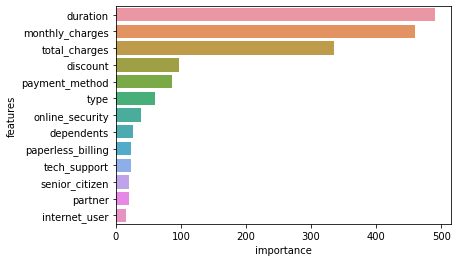

In [ ]:
best_model_importance = best_model.best_estimator_.feature_importances_

best_model_feature_importance_df = pd.DataFrame(
    {'features': features_train_ord.columns.tolist(),
     'importance': best_model_importance.tolist()
    })

best_model_feature_importance_df['abs'] = abs(best_model_feature_importance_df['importance'])

sns.barplot(data = best_model_feature_importance_df.sort_values(by = 'abs', ascending = False), y = 'features', x = 'importance', orient = 'h');

# Тестирование модели

In [ ]:
probabilities_test = best_model.best_estimator_.predict_proba(features_test_ord)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)

print("ROC-AUC лучшей модели на тестовой выборке:", auc_roc)

ROC-AUC лучшей модели на тестовой выборке: 0.8901427619731651


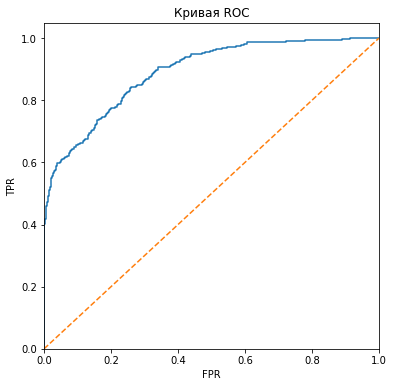

In [ ]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC')
plt.plot([0,1],[0,1], '--')
plt.show()

In [ ]:
accuracy = accuracy_score(target_test, best_model.best_estimator_.predict(features_test_ord))

print("accuracy лучшей модели на тестовой выборке:", accuracy)

accuracy лучшей модели на тестовой выборке: 0.8128113879003559


# Вывод

Данные были предобработаны, объединены и проанализированы. Были созданы дополнетельные признаки duration и over_charges.

Данные были разделены на обучающую и тестовую выборки в соотношении 80/20. К категориальным признакам было применено порядковое кодирование, а к численным - масштабирование.

Выбор модели LGBM был сделан по наивысшему значению метрики ROC-AUC при кросс-валидации по следующим моделям:

* логистической регрессии,
* дерева решений,
* случайного леса,
* LGBM,
* XGBM,
* CatBoost

В результате исследовательского анализа были выявлены наименее значимые признаки (имеющие наименьший коэффициент корреляции Пирсона с целевым признаком), убрав из обучения которые удалось достичь значения метрики ROC-AUC на тестовой выборке 89%.

Метрика accuracy при этом равна 81%, что является достаточно низким значением.

# Отчёт

## Введение


Оператор связи «Ниединогоразрыва.ком» поставил следующую цель - прогноз оттока клиентов на основе персональных данных о клиентах, информации об их тарифах и договорах.

Цель проекта может быть сформулирована следующим образом: метрика AUC-ROC должна быть максимизирована для признака, отражающего уход клиента.

Для достижения поставленной цели были определены и выполнены следующие задачи:

* Загрузка и предобработка данных
* Исследовательский анализ данных
* Составление плана по выбору модели машинного обучения
* Выбор модели 
* Тестирование модели

## Исходные данные и методы исследования

Исходные данные находятся в 4-х таблицах, включая:
* персональные данные о клиентах
* данные об их договорах
* данные о подключенных интернет-услугах
* данные о подключенных услугах телефонии

Каждая из таблиц имеет общую колонку с уникальным номером клиента, посредством которой таблицы могут быть объединены в единую базу данных.

Выполнение проекта осуществлялось на языке Python в Jupiter Notebook и Colab. Использовались открытые библиотеки:
* pandas и numpy для общих процедур работы с данными,
* matplotlib и seaborn для визуализации,
* sklearn, lightgbm, xgboost и catboost для работы с моделями машинного обучения

## Результаты исследования

### Предобработка данных

Предобработка данных включала объединение таблиц и заполнение пропусков, связанных с тем, что не все клиенты пользовались интернетом или, наборот, телефоном. Наиболее полной по отношению к уникальным номерам клентов таблицей является таблица с информацией о договорах. Объединение таблиц и заполнение пропусков необходимо для обеспечения возможности обучения моделей.

Данные включают также бинарные или категориальные признаки о подключённых услугах и персональных данных, количественные признаки о тратах клиентов, а также признаки с датой начала и окончания пользования услугами.

Гистограмма значений даты начала пользования услугами клиентами имеет резкие скачки, не характерные для планомерного разития компании: резкое увеличиение количества пользователей на границе 2013 и 2014 гг. и их резкое сокращение на границе 2019 и 2020 гг. Для обеспечения реалистичности входной информации периоды до 2014 и после 2020 гг. были отсечены из выборки. Если этого не делать, то модель обучится на данных, отражающих либо очень редкое событие слияния и поглощения, либо содержащих ошибки и не сможет прогнозировать на обычных данных без ошибок.

Для выполнения задачи машинного обучения был создан целевой признак машинного обучения: из информации о дате ухода клиента (end_date) сформирован бинарный параметр lost, принимающий значение 0 (данных в колонке end_date нет, т.е. клиент не ушёл) или 1 (клиент ушёл, т.е. имеется дата в колонке end_date).

Также был создан признак duration, отражающий длительность пользования услугами клиента. Он был рассчитан как разница даты актуальности базы данных или даты ухода клиента и даты начала пользования услугами.

Исходя из информации о том, что в компании планируют предлагать промокоды и специальные условия клиентам, которые будут определены как потенциально уходящие, было сделано предположение, что подобная политика уже могла проводиться ранее. На основе личного опыта также известно, что операторы связи часто подключают пользователям лишние услуги и зарабатывают на этом деньги. В связи с этим были созданы следующие признаки:
* over_charges - количественный признак, разница общих трат клиента и произведения количества месяцев пользования услугами  и месячных трат клиента, принимает положительные (компания заработала на клиенте больше положенного) и отрицательные (компания предоставила клиенту скидку) значения
* discount - бинарный признак, равен 0, если over_charges отрицательное значение и 1, если over_charges - положительное значение.

Некоторые пользователи пользуются либо телефоном, либо интернетом и это было необходимо отразить в виде признаков. Клиенты, которые не пользуются телефоном, были отражены в признаке multiple_lines: в качестве пропущенных значений были поставлены значения "no_phone". Отображение подключённых интернет-услуг представлено во вновь созданном бинарном признаке internet_user.

Добавление новых признаков необходимо для обеспечения разнообразия данных, между которыми могут появиться новые связи, помогающие обучаться и прогнозировать.

### Исследовательский анализ данных

Целевой признак является несбалансированным, что было учтено на последующих шагах.

На основе визуализации гистограмм и взаимной зависимости признаков были сформированы представления об их влиянии на целевой признак и взаимозаменяемости.

Клиенты уходят в основном при следующих условиях:
* type: Month-to-month,
* paperless_billing: Yes,
* payment_method: Electronic check,
* internet_service: Fiber optic,
* online_security: No,
* online_backup: No,
* device_protection: No,
* tech_support: No,
* streaming_tv: No,
* streaming_movies: No,
* miltiple_lines: no_phone,
* partner: No,
* dependents: No

От пола и количества подключённых телефонных линий зависимости целевого признака нет.

В результате анализа были определены признаки, оказывающие наименьшее влияние на целевой признак - кандидаты на удаление из выборки для максимизации целевой метрики:
* gender,
* customer_id,
* multiple_lines,
* streaming_movies,
* streaming_tv,
* internet_service,
* device_protection,
* online_backup 

### Составление плана по выбору модели машинного обучения

План был составлен на основе результатов исследовательского анализа данных и включал:
* подготовку данных для машинного обучения, позволяющую избежать утечки данных благодаря разделению данных на обучающую и тренировочную выборки перед их балансировой;
* выбор признаков на основе логистической регрессии;
* выбор модели;
* тестирование модели.

Отклонения от плана были следующие:

из функции для обучения моделей были исключены пункты:
* создание пайплайна для кросс-валидации, включающего 
  * масштабирование количественных признаков
  * балансировка обучающей выборки (увеличение количества единиц, уменьшение количества нулей)

Процедура масштабирования количественных признаков была вынесена вне функции для исключения её повторения на различных моделях.

Процедура балансировки была перенесена в автоматический режим для каждой модели.

### Выбор модели

Подготовка данных для обучения модели включала разделение данных на выборки, кодирование категориальных признаков и масштабирование количественных признаков.

На основе результатов анализа входных данных стало ясно, что необходимо правильно отобрать признаки для модели машинного обучения.

В качестве моделей для отбора признаков были использованы модели логистической регрессии и случайного леса. Гиперпараметры при этом не подбирались, т.е. применялись по умолчанию.

Помимо оценки по встроенным в модели коэффициентам важности моделей, применялись методы permutation_importance и SequentialFeatureSelector.

Результаты отбора всеми методами несколько разнились, но в целом отражали следующее:

* все количественные признаки важны для моделей,
* категориальные признаки, выделенные в результате исследовательского анализа данных, как кандидаты на удаление, действительно являются не самыми важными.

Однако отличия в степени важности признаков для различных моделей и по различным методам определения важности признаков имеют место. Это является неопределённостью, которую следует решать экспериментально.

Для выбора модели были удалены признаки, которые на этапе исследовательского анализа были определены как кандидаты на удаление.

Количественный признак over_charges также был удалён в связи с тем, что оказался наиболее важным для обеих моделей. С одной стороны это можно было бы рассмотреть как положительный знак, с другой же, этот признак по сути вмещает в себя знания компании о том, что клиент собирается уйти (полученные, например, из телефонных разговоров с клиентом) и поэтому является не объективным для обучения модели.

Для оценки работы модели машинного обучения была написана функция, на вход принимающая признаки и целевой признак обучающей выборки, а в качестве результата выдающая обученную модель, результаты предсказания, значение метрики и время обучения и предсказания. Функция включала обучения с кросс-валидацией.

Через эту функцию были пропущены следующие модели с автоматической балансировкой целевого признака:
* логистическая регрессия
* дерево решений
* случайный лес
* LGBM
* XGBM
* CatBoost

Выбор модели был сделан по наивысшей метрике AUC-ROC:

In [ ]:
model_performance

,Model,ROC-AUC,Learning time,Prediction time
0,LR_model_ohe,0.892065,0 days 00:00:03.004267,0 days 00:00:00.002575
1,LR_model_ord,0.894422,0 days 00:00:00.720451,0 days 00:00:00.002178
2,DT_model,0.898570,0 days 00:00:01.728605,0 days 00:00:00.002762
3,RF_model,0.907858,0 days 00:00:07.859495,0 days 00:00:00.004812
4,gbm_cv,0.923169,0 days 00:01:30.998397,0 days 00:00:00.010455
5,xgb_model,0.920843,0 days 00:02:38.573548,0 days 00:00:00.008689
6,CBM,0.910650,0 days 00:02:02.008159,0 days 00:00:00.002162


Наилучший результат показала модель LGBM:

AUC-ROC 0,92

Гиперпараметры наилучшей модели:
* max_depth: 6,
* num_leaves: 18

Наиболее значимыми признаками оказались все количественные:
* duration - потому, что то насколько долго клиент пользуется услугами отражает его лояльность,
* monthly_charges - потому, что месячная оплата это  признак определяющий вероятность ухода клиента к конкуренту в связи с более привлекательной ценой,
* total_charges - потому, что это производная первых двух признаков.

и категориальные:
* discount - потому что если клиент получает скидки и промокоды, он склонен оставаться дольше 
* payment_method - если клиенту удобно платить, то он экономит время
* type - потому что разные тарифы определяют разную месячную плату
* online_security - потому что наличие проблем с безопасностью может отразиться на лояльности клиента

### Тестирование модели

На тестовой выборке наилучшая модель LGBM показала  значение метрики AUC-ROC 0,89.

Также была рассчитана метрика accuracy, значение которой составило 0,81.

## Затруднения в коде исследования и подготовки решения

В ходе выполнения проекта были встречены следующие трудности в коде:

* при объединении таблиц методом join количество строк оказалось меньше ожидаемого, решение проблемы - использование метода merge;
* построение графиков на основе facetgrid заняло продолжительное время, решение - ознакомление с документацией;
* балансировка признаков - была встречена ошибка при выполнении, решение проблемы - применение автоматической балансировки для каждой модели.

## Заключение

В результате исследования была выбрана модель LGBM, показавшая наилучший результат по метрике AUC-ROC, составляющий 0,89.

Наиболее важной задачей для совершенствования модели в настоящий момент видится определение признаков. Полученный результат основан на признаках отобранных по результатам исследовательского анализа данных. Однако по результатам отбора признаков на основе моделей логистической регрессии и случайного леса признаки несколько отличаются. Логичным продолжением исследования видится более детальная работа по перебору признаков. Например, либо использованием наиболее значимых признаков, полученных по каждому методу отбора, либо использования одного универсального набора, основыванного на частоте появления признаков при отборе разными методами.